In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load transaction data
transaction_df = pd.read_csv("/content/transaction_data.csv")

# Load customer purchase behavior data
purchase_df = pd.read_csv("/content/purchase_behaviour.csv")

# Merge both datasets based on LYLTY_CARD_NBR
merged_df = transaction_df.merge(purchase_df, on="LYLTY_CARD_NBR", how="left")

# Convert DATE column to datetime format
merged_df["DATE"] = pd.to_datetime(merged_df["DATE"])

# Display the first few rows to verify merging
print(merged_df.head())

                           DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0 1970-01-01 00:00:00.000043390          1            1000       1         5   
1 1970-01-01 00:00:00.000043599          1            1307     348        66   
2 1970-01-01 00:00:00.000043605          1            1343     383        61   
3 1970-01-01 00:00:00.000043329          2            2373     974        69   
4 1970-01-01 00:00:00.000043330          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  \
0    Natural Chip        Compny SeaSalt175g         2        6.0   
1                  CCs Nacho Cheese    175g         3        6.3   
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9   
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0   
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8   

                LIFESTAGE PREMIUM_CUSTOMER  
0   YOUNG SINGLES/COUPLES          Premium  
1  MIDAGE SINGLES/CO

In [2]:
import datetime as dt

# Define the latest date in the dataset
latest_date = merged_df["DATE"].max()

# Group by customer and calculate RFM metrics
rfm_df = merged_df.groupby("LYLTY_CARD_NBR").agg(
    Recency=("DATE", lambda x: (latest_date - x.max()).days),  # Days since last purchase
    Frequency=("TXN_ID", "nunique"),  # Unique transaction count
    Monetary=("TOT_SALES", "sum")  # Total spending
).reset_index()

# Display first few rows
print("\nRFM Metrics:\n", rfm_df.head())


RFM Metrics:
    LYLTY_CARD_NBR  Recency  Frequency  Monetary
0            1000        0          1       6.0
1            1002        0          1       2.7
2            1003        0          2       6.6
3            1004        0          1       1.9
4            1005        0          1       2.8


In [5]:
# Assign scores using quartiles (handling duplicate edges)
rfm_df["R_Score"] = pd.qcut(rfm_df["Recency"].rank(method="first"), 4, labels=[4, 3, 2, 1], duplicates='drop')
rfm_df["F_Score"] = pd.qcut(rfm_df["Frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4], duplicates='drop')
rfm_df["M_Score"] = pd.qcut(rfm_df["Monetary"].rank(method="first"), 4, labels=[1, 2, 3, 4], duplicates='drop')

# Convert to integers
rfm_df["R_Score"] = rfm_df["R_Score"].astype(int)
rfm_df["F_Score"] = rfm_df["F_Score"].astype(int)
rfm_df["M_Score"] = rfm_df["M_Score"].astype(int)

# Calculate total RFM Score
rfm_df["RFM_Score"] = rfm_df["R_Score"] + rfm_df["F_Score"] + rfm_df["M_Score"]

# Display first few rows
print(rfm_df.head())

   LYLTY_CARD_NBR  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0            1000        0          1       6.0        4        1        1   
1            1002        0          1       2.7        4        1        1   
2            1003        0          2       6.6        4        2        1   
3            1004        0          1       1.9        4        1        1   
4            1005        0          1       2.8        4        1        1   

   RFM_Score  
0          6  
1          6  
2          7  
3          6  
4          6  


In [6]:
# Function to classify customers based on RFM Score
def classify_rfm(score):
    if score >= 10:
        return "High-Value Customer"
    elif score >= 7:
        return "Loyal Customer"
    elif score >= 4:
        return "Potential Customer"
    else:
        return "Low-Value Customer"

# Apply classification
rfm_df["Customer_Segment"] = rfm_df["RFM_Score"].apply(classify_rfm)

# Display customer segmentation counts
print("\nCustomer Segments:\n", rfm_df["Customer_Segment"].value_counts())


Customer Segments:
 Customer_Segment
Loyal Customer         29771
Potential Customer     23530
High-Value Customer    16319
Low-Value Customer      3017
Name: count, dtype: int64


In [7]:
# Calculate Average Spending per Purchase
rfm_df["Avg_Spending"] = rfm_df["Monetary"] / rfm_df["Frequency"]

# Estimate CLV assuming yearly purchases
rfm_df["CLV"] = rfm_df["Avg_Spending"] * rfm_df["Frequency"] * 12

# Sort customers by CLV to find high-value customers
high_clv_customers = rfm_df.sort_values(by="CLV", ascending=False).head(10)

# Display top 10 high CLV customers
print("\nTop 10 High-Value Customers (Based on CLV):\n", high_clv_customers)


Top 10 High-Value Customers (Based on CLV):
        LYLTY_CARD_NBR  Recency  Frequency  Monetary  R_Score  F_Score  \
59694          226000        0          2   1300.00        1        2   
60925          230078        0         17    138.60        1        4   
17292           63197        0         15    132.80        4        4   
69017          259009        0         13    127.20        1        4   
42813          162039        0         18    126.80        2        4   
16001           58361        0         12    124.80        4        4   
61001          230154        0         14    124.40        1        4   
25958           94185        0         16    122.80        3        4   
35338          130090        0         14    122.65        3        4   
47959          179228        0         16    120.80        2        4   

       M_Score  RFM_Score     Customer_Segment  Avg_Spending      CLV  
59694        4          7       Loyal Customer    650.000000  15600.0  
60925 

In [8]:
# Merge RFM & CLV with customer demographic data
customer_analysis = rfm_df.merge(purchase_df, on="LYLTY_CARD_NBR", how="left")

# Display high-value customer details
print("\nHigh-Value Customer Segments:\n")
print(customer_analysis[["LYLTY_CARD_NBR", "Customer_Segment", "CLV", "LIFESTAGE", "PREMIUM_CUSTOMER"]].head(10))


High-Value Customer Segments:

   LYLTY_CARD_NBR    Customer_Segment    CLV               LIFESTAGE  \
0            1000  Potential Customer   72.0   YOUNG SINGLES/COUPLES   
1            1002  Potential Customer   32.4   YOUNG SINGLES/COUPLES   
2            1003      Loyal Customer   79.2          YOUNG FAMILIES   
3            1004  Potential Customer   22.8   OLDER SINGLES/COUPLES   
4            1005  Potential Customer   33.6  MIDAGE SINGLES/COUPLES   
5            1007      Loyal Customer   78.0   YOUNG SINGLES/COUPLES   
6            1009  Potential Customer   68.4            NEW FAMILIES   
7            1010      Loyal Customer  166.8   YOUNG SINGLES/COUPLES   
8            1011      Loyal Customer  216.0   OLDER SINGLES/COUPLES   
9            1012      Loyal Customer  123.6          OLDER FAMILIES   

  PREMIUM_CUSTOMER  
0          Premium  
1       Mainstream  
2           Budget  
3       Mainstream  
4       Mainstream  
5           Budget  
6          Premium  
7      

<ipython-input-9-ef1bb925c9fc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=customer_analysis["Customer_Segment"], palette="viridis")


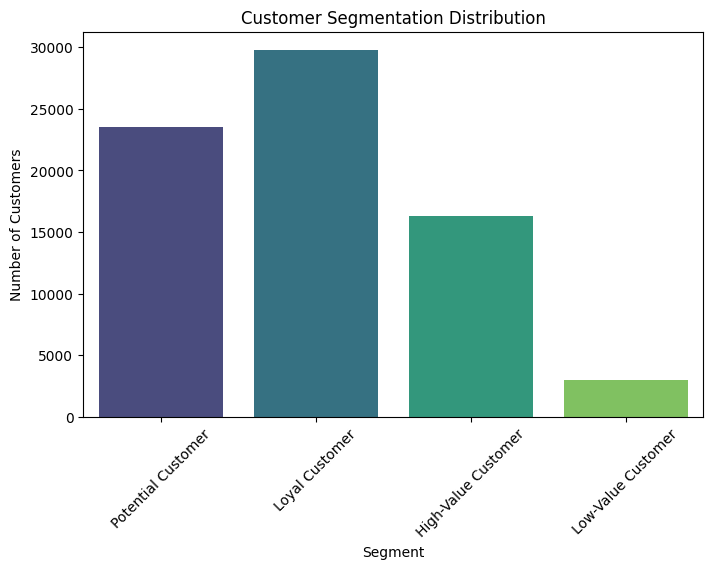

In [9]:
# Visualizing the distribution of customer segments
plt.figure(figsize=(8, 5))
sns.countplot(x=customer_analysis["Customer_Segment"], palette="viridis")
plt.title("Customer Segmentation Distribution")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()

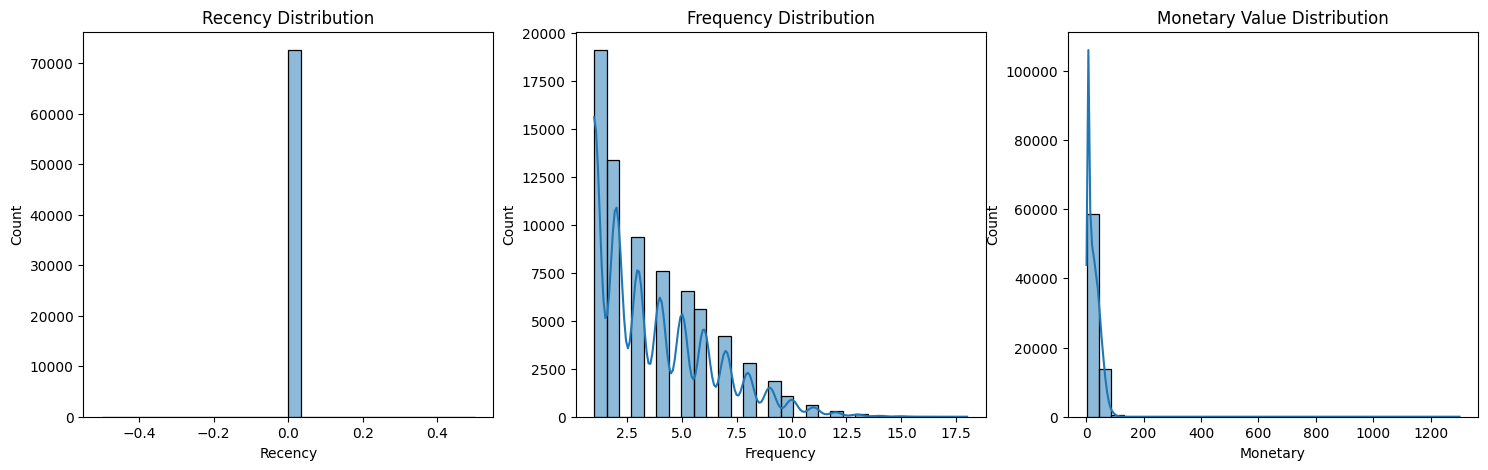

In [10]:
# Histograms for RFM variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm_df["Recency"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.histplot(rfm_df["Frequency"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Frequency Distribution")

sns.histplot(rfm_df["Monetary"], bins=30, kde=True, ax=axes[2])
axes[2].set_title("Monetary Value Distribution")

plt.show()

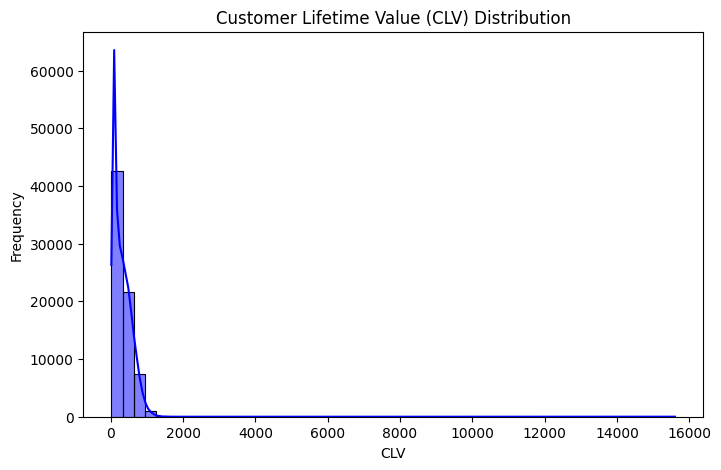

In [11]:
# CLV distribution
plt.figure(figsize=(8, 5))
sns.histplot(rfm_df["CLV"], bins=50, kde=True, color="blue")
plt.title("Customer Lifetime Value (CLV) Distribution")
plt.xlabel("CLV")
plt.ylabel("Frequency")
plt.show()